# Project Title - Room Occupancy Estimation

### Submitted By Gagana Balehonnur Ganesh

MileStone - Model Tranining and Selection

### Content
    1. Problem Definition
    2. Data Collection
    3. Data Preprocessing
    4. Data Clean-up
    5. Exploratory Data Analysis
    6. Visualization
    7. Model Traning and Evaluation
    8. Model Selection

### Problem Dedinition

Problem Definition: Analyzing the experimental data which was collected for a period of 4 days. The data was collected using a setup of 6 cross 4.6-meter room which consisted 7 sensor nodes and 1 edge node. The sensor nodes transmitted data to the edge node for every 30 seconds interval using transceivers. The environmental attributes considered were temperature, sound, light, carbon dioxide level, and digital invasive infrared. No heating, ventilation or air conditioning was used in the room for this experiment. Also, manually the number of occupants count was noted down. I am going to use this data to prediction of number of people in the room. This process includes -

    1. Collecting and analyzing the data
    2. Identifying the pattern
    3. Predicting the number of people in room using machine learning model.
    4. Visualization or presentation of the report.

### Data Source

I am using the “Room Occupancy Estimation Data Set” which is published on the UCI website - https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation

### Importing required packages

In [1]:
%%capture
!pip install basemap-data-hires
!pip install geopandas
!pip install mplcursors
!pip install plotly

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from sklearn import preprocessing
import geopandas as gpd
from time import *
#from mpl_toolkits.basemap import Basemap
import mplcursors

#preprocessing libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import optimize,stats
from abc import ABC, abstractmethod
from numpy.core.umath_tests import inner1d
from copy import deepcopy
from sklearn import preprocessing

### Loading data downloaded from source

In [3]:
OccupancyData = pd.read_csv("Occupancy_Estimation.csv") 
OccupancyData.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [4]:
#Shape of the data
OccupancyData.shape

(10129, 19)

### Dataframe row and columns definition

In [5]:
OccupancyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

### Cleanup

Preprocessing and cleaning up data is an important aspect of data analysis. I am dropping few unnecessary columns

In [6]:
#Dropping Report Date and Time columns

OccupancyData = OccupancyData.drop(columns = ['Date','Time'])

# These columns will not be used to predict number of people in the room.

In [7]:
#checking for null values
OccupancyData.isnull().sum()

S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

We dont have any null data, so our data needs no imputation

Lets check for duplicate data and delete duplicate records

In [8]:
dup = OccupancyData.duplicated()
print(dup.sum())

1301


In [9]:
#dropping duplicate records
OccupancyData.drop_duplicates(keep = 'first', inplace = True)

OccupancyData.shape

(8828, 17)

We will look at the occupancy details we have in our data and see how it is distributed

In [10]:
OccupancyData['Room_Occupancy_Count'].value_counts()

0    6927
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64

### Exploratory Data Analysis with Visuals

We can look at the histogram distribution for the occupancy count

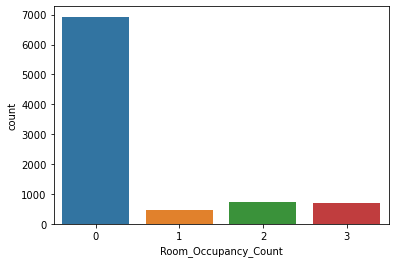

In [13]:
sns.countplot(data = OccupancyData , x = 'Room_Occupancy_Count')
plt.show()

We can see that the data is not uniformly distributed. We have more records for class 0 when compared to other classes.

Heatmap to see correlation between features

<AxesSubplot:>

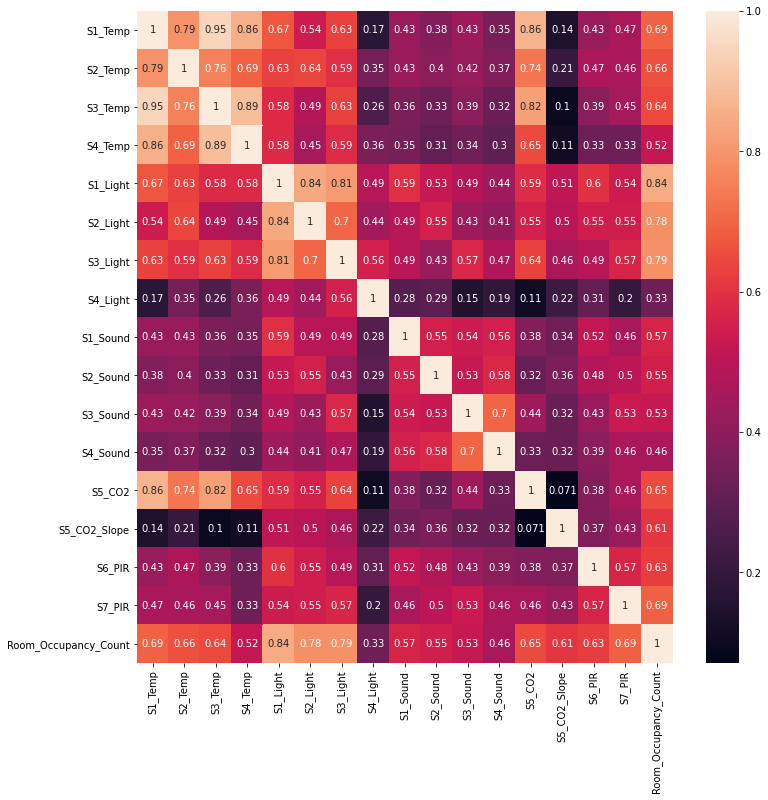

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(OccupancyData.corr(), annot = True)

We can observe that there is high correlation between few columns like temperature and carbon dixoide contents. We can collectively correct this data before moving on to modelling steps.

We can look at the pair plot for few columns to understand the relationship between columns in much better way

<Figure size 1800x1800 with 0 Axes>

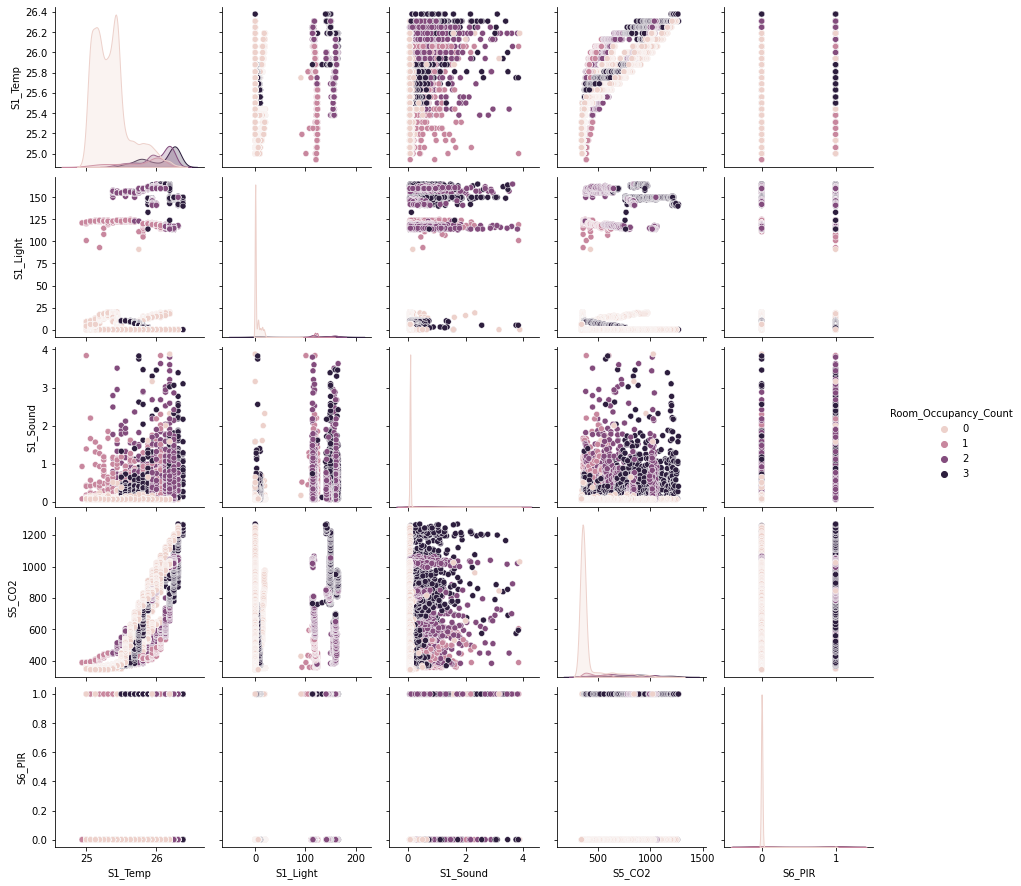

In [15]:
plt.figure(figsize=(12,12),dpi = 150)
sns.pairplot(OccupancyData[['S1_Temp','S1_Light','S1_Sound','S5_CO2','S6_PIR','Room_Occupancy_Count']], hue = 'Room_Occupancy_Count')

By the above pair plot we can clearly observe that column PIR has no relationship with any of the columns. Also, we can observe that temperature and CO2 content are almost proportional to each other.

In [16]:
OccupancyData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8828 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               8828 non-null   float64
 1   S2_Temp               8828 non-null   float64
 2   S3_Temp               8828 non-null   float64
 3   S4_Temp               8828 non-null   float64
 4   S1_Light              8828 non-null   int64  
 5   S2_Light              8828 non-null   int64  
 6   S3_Light              8828 non-null   int64  
 7   S4_Light              8828 non-null   int64  
 8   S1_Sound              8828 non-null   float64
 9   S2_Sound              8828 non-null   float64
 10  S3_Sound              8828 non-null   float64
 11  S4_Sound              8828 non-null   float64
 12  S5_CO2                8828 non-null   int64  
 13  S5_CO2_Slope          8828 non-null   float64
 14  S6_PIR                8828 non-null   int64  
 15  S7_PIR              

Checking for outliers in the data using box plot.

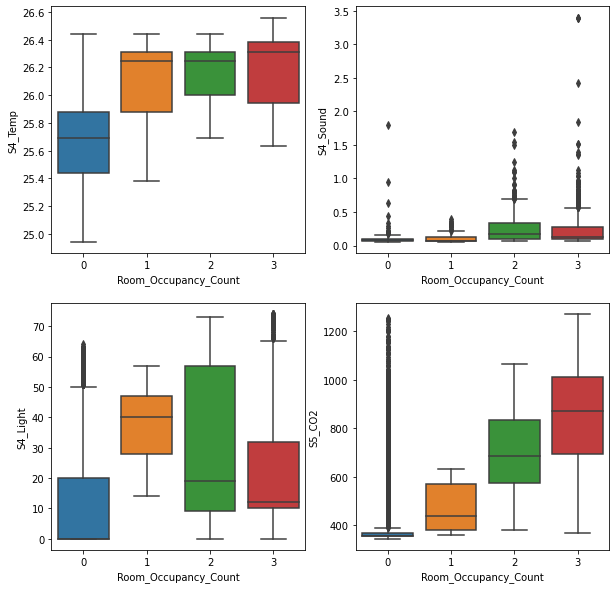

In [17]:
fig,x = plt.subplots(2,2, figsize=(10,10))
cols = ['S4_Temp', 'S4_Light', 'S4_Sound', 'S5_CO2']
for n in range(4):
    sns.boxplot(x='Room_Occupancy_Count', y=cols[n], data=OccupancyData, ax=x[n%2,n//2])

We can clearly see some outliers for the Sound, Light and CO2 columns. We can remove these outliers using Z-score method.

In [18]:
df = OccupancyData
df = df[np.abs(df.S4_Sound - df.S4_Sound.mean()) <= 3*df.S4_Sound.std()]
print("1. Removing the Outliers on 'S4_Sound' has reduced the data size from {} to {}.".format(len(OccupancyData), len(df)))
print("\n")

1. Removing the Outliers on 'S4_Sound' has reduced the data size from 8828 to 8656.




In [19]:
df = df[np.abs(df.S5_CO2 - df.S5_CO2.mean()) <= 3*df.S5_CO2.std()]
print("2. Removing the Outliers on 'S5_CO2' has reduced the data size from {} to {}.".format(len(OccupancyData), len(df)))
print("\n")

2. Removing the Outliers on 'S5_CO2' has reduced the data size from 8828 to 8523.




In [20]:
df = df[np.abs(df.S4_Light - df.S4_Light.mean()) <= 3*df.S4_Light.std()]
print("3. Removing the Outliers on 'S4_Light' has reduced the data size from {} to {}.".format(len(OccupancyData), len(df)))
print("\n")

3. Removing the Outliers on 'S4_Light' has reduced the data size from 8828 to 8523.




Replotting the data after removing outliers.

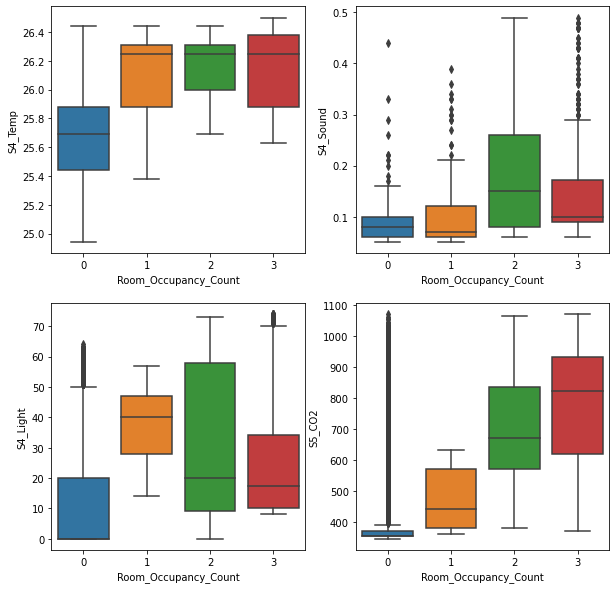

In [21]:
fig,x = plt.subplots(2,2, figsize=(10,10))
cols = ['S4_Temp', 'S4_Light', 'S4_Sound', 'S5_CO2']
for n in range(4):
    sns.boxplot(x='Room_Occupancy_Count', y=cols[n], data=df, ax=x[n%2,n//2])

We can see better data distribution after removing the ouliers.

## Defining some custom classification models - Since it is multi-class classification, using the below models - 

### 1. Multi-Class Logistic Regression
### 2. K- Nearest Neigbours
### 3. Decision Tress
### 4. Ada Boost Classifier
### 5. Support Vector Machine
### 6. Neural Networks


### Multi-Class Logistic Regression

In [22]:
class LogisticRegressionMultiClass():
    """
    Class for logisttic regression
    """

    def __init__(self, lr=0.001, epochs=1000):
        """
        Logistic Regression Constructor

        Args:
            lr (float, optional): _description_. Defaults to 0.001.
            epochs (int, optional): _description_. Defaults to 1000.
        """
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None
        

    def lossCrossEntropy(self,probabilities, target):
      #Calculating cross entropy loss for prediction probablities and actual targets.
      #Returns Loss- Average cross entropy loss
        n_samples = probabilities.shape[0]
        Loss = 0
        for sample, i in zip(probabilities, target):
            Loss += -np.log(sample[i])
        Loss /= n_samples
        return Loss 

    def predict(self,X, w, b):
        logitScores = np.array([np.empty([6]) for i in range(X.shape[0])]) # creating empty(garbage value) array for each feature set
    
        for i in range(X.shape[0]): # iterating through each feature set
            logitScores[i] = (w.dot(X[i].reshape(-1,1)) + b).reshape(-1) # calculates logit score for each feature set then flattens the logit vector 
    
        return logitScores

    def softmax(self,logit):
        probabilities = np.array([np.empty([6]) for i in range(logit.shape[0])]) # creating empty(garbage value) array for each feature set

        for i in range(logit.shape[0]):
            exp = np.exp(logit[i]) # exponentiates each element of the logit array
            sumOfArr = np.sum(exp) # adds up all the values in the exponentiated array
            probabilities[i] = exp/sumOfArr # logit scores to probability values
        return probabilities

    def multiLogReg(self,X, w, b):
        logitScores = self.predict(X, w, b)
        probabilities = self.softmax(logitScores)
        predictions = np.array([np.argmax(i) for i in probabilities]) #returns the outcome with max probability
        return probabilities, predictions
    
   
    def stochGradDes(self,lr, epochs, Y, X, w, b):
        Y = Y.astype(int)
        loss_list = np.array([]) #initiating an empty array
    
        for i in range(epochs):
            probabilities, _ = self.multiLogReg(X, w, b) # Calculates probabilities for each possible outcome
        
            CELoss = self.lossCrossEntropy(probabilities, Y) # Calculates cross entropy loss for actual target and predictions
            loss_list = np.append(loss_list, CELoss) # Adds the CELoss value for the epoch to loss_list
        
            probabilities[np.arange(X.shape[0]),Y] -= 1 # Substract 1 from the scores of the correct outcome
        
            grad_weight = probabilities.T.dot(X) # gradient of loss w.r.t. weights
            grad_biases = np.sum(probabilities, axis = 0).reshape(-1,1) # gradient of loss w.r.t. biases
        
            #updating weights and biases
            w -= (lr * grad_weight)
            b -= (lr * grad_biases)
        
        return w, b, loss_list


    def accuracy(self,yhat, Y):
        correctPred = 0
        for i in range(len(yhat)):
            if yhat[i] == Y[i]:
                correctPred += 1
        accuracy = correctPred/len(yhat)*100
        return accuracy

### K-Nearest Neighbours

In [23]:
class KNN(ABC):
    """
    Base class for KNN implementations
    """
    
    def __init__(self, K : int = 3, metric : str = 'minkowski', p : int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatiable.
        Inputs:
            K      -> integer specifying number of neighbours to consider
            metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
            p      -> order of the minkowski metric (valid only when distance == 'minkowski')
        """
        # check distance is a valid entry
        valid_distance = ['minkowski','cosine']
        if metric not in valid_distance:
            msg = "Entered value for metric is not valid. Pick one of {}".format(valid_distance)
            raise ValueError(msg)
        # check minkowski p parameter
        if (metric == 'minkowski') and (p <= 0):
            msg = "Entered value for p is not valid. For metric = 'minkowski', p >= 1"
            raise ValueError(msg)
        # store/initialise input parameters
        self.K       = K
        self.metric  = metric
        self.p       = p
        self.X_train = np.array([])
        self.y_train = np.array([])
        
    def __del__(self) -> None:
        """
        Destructor function. 
        """
        del self.K
        del self.metric
        del self.p
        del self.X_train
        del self.y_train
      
    def __minkowski(self, x : np.array) -> np.array:
        """
        Private function to compute the minkowski distance between point x and the training data X
        Inputs:
            x -> numpy data point of predictors to consider
        Outputs:
            np.array -> numpy array of the computed distances
        """
        return np.power(np.sum(np.power(np.abs(self.X_train - x),self.p),axis=1),1/self.p)
    
    def __cosine(self, x : np.array) -> np.array:
        """
        Private function to compute the cosine distance between point x and the training data X
        Inputs:
            x -> numpy data point of predictors to consider
        Outputs:
            np.array -> numpy array of the computed distances
        """
        return (1 - (np.dot(self.X_train,x)/(np.linalg.norm(x)*np.linalg.norm(self.X_train,axis=1))))
    
    def __distances(self, X : np.array) -> np.array:
        """
        Private function to compute distances to each point x in X[x,:]
        Inputs:
            X -> numpy array of points [x]
        Outputs:
            D -> numpy array containing distances from x to all points in the training set.
        """
        # cover distance calculation
        if self.metric == 'minkowski':
            D = np.apply_along_axis(self.__minkowski,1,X)
        elif self.metric == 'cosine':
            D = np.apply_along_axis(self.__cosine,1,X)
        # return computed distances
        return D
    
    @abstractmethod
    def _generate_predictions(self, idx_neighbours : np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours
        """
        pass
        
    def fit(self, X : np.array, y : np.array) -> None:
        """
        Public training function for the class. It is assummed input X has been normalised.
        Inputs:
            X -> numpy array containing the predictor features
            y -> numpy array containing the labels associated with each value in X
        """
        # store training data
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)
        
    def predict(self, X : np.array) -> np.array:
        """
        Public prediction function for the class. 
        It is assummed input X has been normalised in the same fashion as the input to the training function
        Inputs:
            X -> numpy array containing the predictor features
        Outputs:
           y_pred -> numpy array containing the predicted labels
        """
        # ensure we have already trained the instance
        if (self.X_train.size == 0) or (self.y_train.size == 0):
            raise Exception('Model is not trained. Call fit before calling predict.')
        # compute distances
        D = self.__distances(X)
        # obtain indices for the K nearest neighbours
        idx_neighbours = D.argsort()[:,:self.K]
        # compute predictions
        y_pred = self._generate_predictions(idx_neighbours)
        # return results
        return y_pred
    
    def get_params(self, deep : bool = False):
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K,
                'metric':self.metric,
                'p':self.p}

In [24]:
class KNNClassifier(KNN):
    """
    Class for KNN classifiction implementation
    """
    
    def __init__(self, K : int = 3, metric : str = 'minkowski', p : int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatiable.
        Inputs:
            K       -> integer specifying number of neighbours to consider
            metric  -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
            p       -> order of the minkowski metric (valid only when distance == 'minkowski')
        """
        # call base class initialiser
        super().__init__(K,metric,p)
        
    def _generate_predictions(self, idx_neighbours : np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours
        Inputs:
            idx_neighbours -> indices of nearest neighbours
        Outputs:
            y_pred -> numpy array of prediction results
        """        
        # compute the mode label for each submitted sample
        y_pred = stats.mode(self.y_train[idx_neighbours],axis=1).mode.flatten()   
        # return result
        return y_pred

In [73]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score,precision_score,recall_score,f1_score,make_scorer,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score,classification_report
from sklearn.pipeline import Pipeline
from sklearn import tree

In [26]:
## define the scoring metrics ##
scoring_metrics = {'accuracy' : make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score),
                   'recall'   : make_scorer(recall_score),
                   'f1'       : make_scorer(f1_score)}

## define a helper function for our analysis ##

def cv_classifier_analysis(pipe, 
                           X : np.array, 
                           y : np.array, 
                           k : int, 
                           scoring_metrics,
                           metric : str) -> None:
    """
    Function to carry out cross-validation analysis for input KNN classifier
    Inputs:
        pipe            -> input pipeline containing preprocessing and KNN classifier
        X               -> numpy array of predictors
        y               -> numpy array of labels
        k               -> integer value for number of nearest neighbours to consider
        scoring_metrics -> dictionary of scoring metrics to consider 
        metric          -> string indicating distance metric used
    """
    # print hyperparameter configuration
    print('RESULTS FOR K = {0}, {1}'.format(k,metric))
    # run cross validation
    dcScores = cross_validate(pipe,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
    # report results
    print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

### Decision Tree 

In [27]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value
        
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

### Ada Boost Classifier

In [57]:
class AdaBoostClassifier(object):
    def __init__(self, *args, **kwargs):
        if kwargs and args:
            raise ValueError(
                '''AdaBoostClassifier can only be called with keyword
                   arguments for the following keywords: base_estimator ,n_estimators,
                    learning_rate,algorithm,random_state''')
        allowed_keys = ['base_estimator', 'n_estimators', 'learning_rate', 'algorithm', 'random_state']
        keywords_used = kwargs.keys()
        for keyword in keywords_used:
            if keyword not in allowed_keys:
                raise ValueError(keyword + ":  Wrong keyword used --- check spelling")

        n_estimators = 50
        learning_rate = 1
        algorithm = 'SAMME.R'
        random_state = None

        if kwargs and not args:
            if 'base_estimator' in kwargs:
                base_estimator = kwargs.pop('base_estimator')
            else:
                raise ValueError('''base_estimator can not be None''')
            if 'n_estimators' in kwargs: n_estimators = kwargs.pop('n_estimators')
            if 'learning_rate' in kwargs: learning_rate = kwargs.pop('learning_rate')
            if 'algorithm' in kwargs: algorithm = kwargs.pop('algorithm')
            if 'random_state' in kwargs: random_state = kwargs.pop('random_state')

        self.base_estimator_ = base_estimator
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.algorithm_ = algorithm
        self.random_state_ = random_state
        self.estimators_ = list()
        self.estimator_weights_ = np.zeros(self.n_estimators_)
        self.estimator_errors_ = np.ones(self.n_estimators_)


    def _samme_proba(self, estimator, n_classes, X):
        """Calculate algorithm 4, step 2, equation c) of Zhu et al [1].
        References
        ----------
        .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.
        """
        proba = estimator.predict_proba(X)

        # Displace zero probabilities so the log is defined.
        # Also fix negative elements which may occur with
        # negative sample weights.
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)

        return (n_classes - 1) * (log_proba - (1. / n_classes)
                                  * log_proba.sum(axis=1)[:, np.newaxis])


    def fit(self, X, y):
        self.n_samples = X.shape[0]
        # There is hidden trouble for classes, here the classes will be sorted.
        # So in boost we have to ensure that the predict results have the same classes sort
        self.classes_ = np.array(sorted(list(set(y))))
        self.n_classes_ = len(self.classes_)
        for iboost in range(self.n_estimators_):
            if iboost == 0:
                sample_weight = np.ones(self.n_samples) / self.n_samples

            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            # early stop
            if estimator_error == None:
                break

            # append error and weight
            self.estimator_errors_[iboost] = estimator_error
            self.estimator_weights_[iboost] = estimator_weight

            if estimator_error <= 0:
                break

        return self


    def boost(self, X, y, sample_weight):
        if self.algorithm_ == 'SAMME':
            return self.discrete_boost(X, y, sample_weight)
        elif self.algorithm_ == 'SAMME.R':
            return self.real_boost(X, y, sample_weight)

    def real_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1.0 - 1 / self.n_classes_:
            return None, None, None

        y_predict_proba = estimator.predict_proba(X)
        # repalce zero
        y_predict_proba[y_predict_proba < np.finfo(y_predict_proba.dtype).eps] = np.finfo(y_predict_proba.dtype).eps

        y_codes = np.array([-1. / (self.n_classes_ - 1), 1.])
        y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])

        # for sample weight update
        intermediate_variable = (-1. * self.learning_rate_ * (((self.n_classes_ - 1) / self.n_classes_) *
                                                              inner1d(y_coding, np.log(
                                                                  y_predict_proba))))  #dot iterate for each row

        # update sample weight
        sample_weight *= np.exp(intermediate_variable)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, 1, estimator_error


    def discrete_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        # update estimator_weight
        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(
            self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        # update sample weight
        sample_weight *= np.exp(estimator_weight * incorrect)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = None

        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            pred = sum(self._samme_proba(estimator, n_classes, X) for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)


    def predict_proba(self, X):
        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            proba = sum(self._samme_proba(estimator, self.n_classes_, X)
                        for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_,
                                                self.estimator_weights_))

        proba /= self.estimator_weights_.sum()
        proba = np.exp((1. / (n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba

### Support Vector Machine

In [52]:
class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None


    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        #y_ = np.where(y <= 0, -1, 1)
        y_ = y
        
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def accuracy(self,yhat, Y):
        correctPred = 0
        for i in range(len(yhat)):
            if yhat[i] == Y[i]:
                correctPred += 1
        accuracy = correctPred/len(yhat)*100
        return accuracy

### Neural Networks

In [67]:
class DNNClassifier(object):
    '''
    Parameters: layer_dims -- List Dimensions of layers including input and output layer
                hidden_layers -- List of hidden layers
                                 'relu','sigmoid','tanh','softplus','arctan','elu','identity','softmax'
                                 Note: 1. last layer must be softmax 
                                       2. For relu and elu need to mention alpha value as below
                                        ['tanh',('relu',alpha1),('elu',alpha2),('relu',alpha3),'softmax']
                                        need to give a tuple for relu and elu if you want to mention alpha
                                        if not default alpha is 0
                init_type -- init_type -- he_normal  --> N(0,sqrt(2/fanin))
                             he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                             xavier_normal --> N(0,2/(fanin+fanout))
                             xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                                 
                learning_rate -- Learning rate
                optimization_method -- optimization method 'SGD','SGDM','RMSP','ADAM'
                batch_size -- Batch size to update weights 
                max_epoch -- Max epoch number
                             Note : Max_iter  = max_epoch * (size of traing / batch size)
                tolarance -- if abs(previous cost  - current cost ) < tol training will be stopped
                             if None -- No check will be performed
                keep_proba -- probability for dropout
                              if 1 then there is no dropout
                penality -- regularization penality
                            values taken 'l1','l2',None(default)
                lamda -- l1 or l2 regularization value
                beta1 -- SGDM and adam optimization param
                beta2 -- RMSP and adam optimization value
                seed -- Random seed to generate randomness
                verbose -- takes 0  or 1 
    '''
    
    def __init__(self,layer_dims,hidden_layers,init_type='he_normal',learning_rate=0.1,
                 optimization_method = 'SGD',batch_size=64,max_epoch=100,tolarance = 0.00001,
                 keep_proba=1,penality=None,lamda=0,beta1=0.9,
                 beta2=0.999,seed=None,verbose=0):
        self.layer_dims = layer_dims
        self.hidden_layers = hidden_layers
        self.init_type = init_type
        self.learning_rate = learning_rate
        self.optimization_method = optimization_method
        self.batch_size = batch_size
        self.keep_proba = keep_proba
        self.penality = penality
        self.lamda = lamda
        self.beta1 = beta1
        self.beta2 = beta2
        self.seed = seed
        self.max_epoch = max_epoch
        self.tol = tolarance
        self.verbose = verbose
    @staticmethod
    def weights_init(layer_dims,init_type='he_normal',seed=None):
        
        """
        Arguments:
            layer_dims -- python array (list) containing the dimensions of each layer in our network
            layer_dims lis is like  [ no of input features,# of neurons in hidden layer-1,..,
                                     # of neurons in hidden layer-n shape,output]
            init_type -- he_normal  --> N(0,sqrt(2/fanin))
                         he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                         xavier_normal --> N(0,2/(fanin+fanout))
                         xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                         seed -- random seed to generate weights
        Returns:
            parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
        """
        np.random.seed(seed)
        parameters = {}
        opt_parameters = {}
        L = len(layer_dims)            # number of layers in the network
        if  init_type == 'he_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], 1))  
            
        elif init_type == 'he_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], 1))
            
        elif init_type == 'xavier_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                   (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                      (layer_dims[l], 1)) 
            
        elif init_type == 'xavier_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], 1))
        
        return parameters
    
    @staticmethod
    def sigmoid(X,derivative=False):
        '''Compute Sigmaoid and its derivative'''
        if derivative == False:
            out = 1 / (1 + np.exp(-np.array(X)))
        elif derivative == True:
            s = 1 / (1 + np.exp(-np.array(X)))
            out = s*(1-s)
        return out
    @staticmethod
    def ReLU(X,alpha=0,derivative=False):
        '''Compute ReLU function and derivative'''
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*X,X)
        elif derivative == True:
            X_relu = np.ones_like(X,dtype=np.float64)
            X_relu[X < 0] = alpha
            return X_relu
    @staticmethod
    def Tanh(X,derivative=False):
        '''Compute tanh values and derivative of tanh'''
        X = np.array(X)
        if derivative == False:
            return np.tanh(X)
        if derivative == True:
            return 1 - (np.tanh(X))**2
    @staticmethod
    def softplus(X,derivative=False):
        '''Compute tanh values and derivative of tanh'''
        X = np.array(X)
        if derivative == False:
            return np.log(1+np.exp(X))
        if derivative == True:
            return 1 / (1 + np.exp(-np.array(X)))
    @staticmethod
    def arctan(X,derivative=False):
        '''Compute tan^-1(X) and derivative'''
        if derivative == False:
            return  np.arctan(X)
        if derivative == True:
            return 1/ (1 + np.square(X))
    @staticmethod
    def identity(X,derivative=False):
        '''identity function and derivative f(x) = x'''
        X = np.array(X)
        if derivative ==  False:
            return X
        if derivative == True:
            return np.ones_like(X)
    @staticmethod
    def elu(X,alpha=0,derivative=False):
        '''Exponential Linear Unit'''
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*(np.exp(X)-1),X)
        elif derivative == True:
            return np.where(X<0,alpha*(np.exp(X)),1)
    @staticmethod
    def softmax(X):
        """Compute softmax values for each sets of scores in x."""
        return np.exp(X) / np.sum(np.exp(X),axis=0)
    @staticmethod
    def forward_propagation(X, hidden_layers,parameters,keep_prob=1,seed=None):
    
        """"
        Arguments:
            X -- data, numpy array of shape (input size, number of examples)
            hidden_layers -- List of hideden layers
            weights -- Output of weights_init dict (parameters)
            keep_prob -- probability of keeping a neuron active during drop-out, scalar
        Returns:
            AL -- last post-activation value
            caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
        """
        if seed != None:
            np.random.seed(seed)
        caches = []
        A = X
        L = len(hidden_layers)
        for l,active_function in enumerate(hidden_layers,start=1):
            A_prev = A 
        
            Z = np.dot(parameters['W' + str(l)],A_prev)+parameters['b' + str(l)]
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    A = DNNClassifier.ReLU(Z,active_function[1])
                elif active_function[0] == 'elu':
                    A = DNNClassifier.elu(Z,active_function[1])
            else:
                if active_function == "sigmoid":
                    A = DNNClassifier.sigmoid(Z)
                elif active_function == "identity":
                    A = DNNClassifier.identity(Z)
                elif active_function == "arctan":
                    A = DNNClassifier.arctan(Z)
                elif active_function == "softplus":
                    A = DNNClassifier.softplus(Z)
                elif active_function == "tanh":
                    A = DNNClassifier.Tanh(Z)
                elif active_function == "softmax":
                    A = DNNClassifier.softmax(Z)
                elif  active_function == "relu":
                    A = DNNClassifier.ReLU(Z)
                elif active_function == 'elu':
                    A = DNNClassifier.elu(Z)
            
            if keep_prob != 1 and l != L and l != 1:
                D = np.random.rand(A.shape[0],A.shape[1])
                D = (D<keep_prob)
                A = np.multiply(A,D)
                A = A / keep_prob
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)],D), Z)
                caches.append(cache)
            else:
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)]), Z)
                #print(A.shape)
                caches.append(cache)      
        return A, caches
    @staticmethod
    def compute_cost(A, Y, parameters, lamda=0,penality=None):
        """
        Implement the cost function with L2 regularization. See formula (2) above.
    
        Arguments:
            A -- post-activation, output of forward propagation
            Y -- "true" labels vector, of shape (output size, number of examples)
            parameters -- python dictionary containing parameters of the model
    
        Returns:
            cost - value of the regularized loss function 
        """
        m = Y.shape[1]
    
        cost = np.squeeze(-np.sum(np.multiply(np.log(A),Y))/m)
    
        L = len(parameters)//2
    
        if penality == 'l2' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.square(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        elif penality == 'l1' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.abs(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        return cost
    @staticmethod
    def back_propagation(AL, Y, caches, hidden_layers, keep_prob=1, penality=None,lamda=0):
        """
        Implement the backward propagation
    
        Arguments:
            AL -- probability vector, output of the forward propagation (L_model_forward())
            Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
            caches -- list of caches containing:
            hidden_layers -- hidden layer names
            keep_prob -- probabaility for dropout
            penality -- regularization penality 'l1' or 'l2' or None
    
        Returns:
             grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
        """
        grads = {}
        L = len(caches) # the number of layers
    
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
    
        # Initializing the backpropagation
        dZL = AL - Y
    
        cache = caches[L-1]
        linear_cache, activation_cache = cache
        AL, W, b = linear_cache
        grads["dW" + str(L)] = np.dot(dZL,AL.T)/m
        grads["db" + str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
        grads["dA" + str(L-1)] = np.dot(W.T,dZL)
    
    
        # Loop from l=L-2 to l=0
        v_dropout = 0
        for l in reversed(range(L-1)):
            cache = caches[l]
            active_function = hidden_layers[l]
        
            linear_cache, Z = cache
            try:
                A_prev, W, b = linear_cache
            except:
                A_prev, W, b, D = linear_cache
                v_dropout = 1
            
            m = A_prev.shape[1]
        
            if keep_prob != 1 and v_dropout == 1:
                dA_prev = np.multiply(grads["dA" + str(l + 1)],D)
                dA_prev = dA_prev/keep_prob
                v_dropout = 0
            else:
                dA_prev = grads["dA" + str(l + 1)]
                v_dropout = 0
            
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    dZ = np.multiply(dA_prev,DNNClassifier.ReLU(Z,active_function[1],derivative=True))
                elif active_function[0] == 'elu':
                    dZ = np.multiply(dA_prev,DNNClassifier.elu(Z,active_function[1],derivative=True))
            else:
                if active_function == "sigmoid":
                    dZ = np.multiply(dA_prev,DNNClassifier.sigmoid(Z,derivative=True))
                elif active_function == "relu":
                    dZ = np.multiply(dA_prev,DNNClassifier.ReLU(Z,derivative=True))
                elif active_function == "tanh":
                    dZ = np.multiply(dA_prev,DNNClassifier.Tanh(Z,derivative=True))
                elif active_function == "identity":
                    dZ = np.multiply(dA_prev,DNNClassifier.identity(Z,derivative=True))
                elif active_function == "arctan":
                    dZ = np.multiply(dA_prev,DNNClassifier.arctan(Z,derivative=True))
                elif active_function == "softplus":
                    dZ = np.multiply(dA_prev,DNNClassifier.softplus(Z,derivative=True))
                elif active_function == 'elu':
                    dZ = np.multiply(dA_prev,DNNClassifier.elu(Z,derivative=True))
            
            grads["dA" + str(l)] = np.dot(W.T,dZ)
        
            if penality == 'l2':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * W)/m)
            elif penality == 'l1':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * np.sign(W+10**-8))/m)
            else:
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)
            
            grads["db" + str(l + 1)] = np.sum(dZ,axis=1,keepdims=True)/m   
        return grads
    
    @staticmethod
    def update_parameters(parameters, grads,learning_rate,iter_no,method = 'SGD',opt_parameters=None,beta1=0.9,beta2=0.999):
        """
        Update parameters using gradient descent
    
        Arguments:
        parameters -- python dictionary containing your parameters 
        grads -- python dictionary containing your gradients, output of L_model_backward
        method -- method for updation of weights
                  'SGD','SGDM','RMSP','ADAM'
        learning rate -- learning rate alpha value
        beta1 -- weighted avg parameter for SGDM and ADAM
        beta2 -- weighted avg parameter for RMSP and ADAM
    
        Returns:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
                      opt_parameters
        """
    
        L = len(parameters) // 2 # number of layers in the neural network
        if method == 'SGD':
            for l in range(L):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
            opt_parameters = None
        elif method == 'SGDM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*opt_parameters['vdw'+str(l+1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*opt_parameters['vdb'+str(l+1)]
        elif method == 'RMSP':
            for l in range(L):
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                     (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                           (1-beta2)*np.square(grads["dW" + str(l + 1)])
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(grads["dW" + str(l + 1)]/(np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(grads["db" + str(l + 1)]/(np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        elif method == 'ADAM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                                  (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                                   (1-beta2)*np.square(grads["dW" + str(l + 1)])
            
                learning_rate = learning_rate * np.sqrt((1-beta2**iter_no)/((1-beta1**iter_no)+10**-8))
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdw'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdb'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        
        return parameters,opt_parameters
    
    def fit(self,X,y):
        '''
        X -- data, numpy array of shape (input size, number of examples)
        y -- lables, numpy array of shape (no of classes,n)
        
        '''
        
        np.random.seed(self.seed)
        self.grads = {}
        self.costs = []
        M = X.shape[1]
        opt_parameters = {}
        
        if self.verbose == 1:
            print('Initilizing Weights...')
        self.parameters = self.weights_init(self.layer_dims,self.init_type,self.seed)
        self.iter_no = 0
        idx = np.arange(0,M)
        
        if self.optimization_method != 'SGD':
            for l in range(1, len(self.layer_dims)):
                opt_parameters['vdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['vdb' + str(l)] = np.zeros((self.layer_dims[l], 1))
                opt_parameters['sdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['sdb' + str(l)] = np.zeros((self.layer_dims[l], 1)) 
        
        if self.verbose == 1:
            print('Starting Training...')
            
        for epoch_no in range(1,self.max_epoch+1):
            np.random.shuffle(idx)
            X = X[:,idx]
            y = y[:,idx]
            for i in range(0,M, self.batch_size):
                self.iter_no = self.iter_no + 1
                X_batch = X[:,i:i + self.batch_size]
                y_batch = y[:,i:i + self.batch_size]
                # Forward propagation:
                AL, cache = self.forward_propagation(X_batch,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
                #cost
                cost = self.compute_cost(AL, y_batch, self.parameters,self.lamda,self.penality)
                self.costs.append(cost)
                
                if self.tol != None:
                    try:
                        if abs(cost - self.costs[-2]) < self.tol:
                            return self
                    except:
                        pass
                #back prop
                grads = self.back_propagation(AL, y_batch, cache,self.hidden_layers,self.keep_proba,self.penality,self.lamda)
                
                #update params
                self.parameters,opt_parameters = self.update_parameters(self.parameters,grads,self.learning_rate,
                                                                        self.iter_no-1,self.optimization_method,
                                                                        opt_parameters,self.beta1,self.beta2)
                
                if self.verbose == 1:
                    if self.iter_no % 100 == 0:
                        print("Cost after iteration {}: {}".format(self.iter_no, cost))
                
        return self
    def predict(self,X,proba=False):
        '''predicting values
           arguments: X - iput data
                      proba -- False then return value
                               True then return probabaility
        '''
        
        out, _ = self.forward_propagation(X,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
        if proba == True:
            return out.T
        else:
            return np.argmax(out, axis=0)
        
    def accuracy(self,yhat, Y):
        correctPred = 0
        for i in range(len(yhat)):
            if yhat[i] == Y[i]:
                correctPred += 1
        accuracy = correctPred/len(yhat)*100
        return accuracy

## Model Training and Evaluation

### Defining features and target variables from the dataset

In [28]:
# selecting all the features within our dataset
Y = df['Room_Occupancy_Count'].to_numpy() # converts target column to numpy array
X = df.drop(columns = 'Room_Occupancy_Count')

# Scale the dataset
sc = StandardScaler()
X = sc.fit_transform(X)

X.shape, len(Y) 

((8523, 16), 8523)

Splitting the dataset into training and test dataset 80:20

In [29]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size = 0.2,random_state=42)

### Traning the Logistic Regression Model

In [32]:
#using some random values for weights and biases initially and training the model
weights = np.random.rand(6, 16)
biases = np.random.rand(6, 1)

mlr = LogisticRegressionMultiClass()

print('training model')
start_time = time()

updatedWeights, updatedBiases, loss_list = mlr.stochGradDes(0.001, 1000, Ytrain, Xtrain, weights, biases)
end_time = time()
elapsed_time = end_time - start_time
print("Time to train Logistic Regression model: %.3f seconds" % elapsed_time)

training model
Time to train Logistic Regression model: 147.420 seconds


### Predicting the room occupancy using test dataset with Logistic Regression model

In [33]:
testProbabilities, testPredictions = mlr.multiLogReg(Xtest, updatedWeights, updatedBiases)
acc = mlr.accuracy(testPredictions,Ytest)
print("Model accuracy on test dataset - {}".format(acc))

Model accuracy on test dataset - 99.2375366568915


In [34]:
dfConfusion = pd.crosstab(Ytest, testPredictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
dfConfusion

Predicted,0,1,2,3,All
Actual,,,,,
0,1360,0,0,0,1360
1,0,102,1,0,103
2,0,0,140,4,144
3,0,0,8,90,98
All,1360,102,149,94,1705


### Traning the K-Nearest Neighbour Model

In [36]:
modelKnn = KNNClassifier(1, metric = 'minkowski', p = 1)
print('training model')
start_time = time()
modelKnn.fit(Xtrain, Ytrain)
end_time = time()
elapsed_time = end_time - start_time
print("Time to train KNN Classifier model: %.3f seconds" % elapsed_time)

training model
Time to train KNN Classifier model: 0.002 seconds


### Predicting the room occupancy using test dataset with K-Nearest Neighbour model

In [37]:
Y_pred_knn = modelKnn.predict(Xtest)
acc = accuracy_score(Ytest,Y_pred_knn)*100
print("Model accuracy on test dataset - {}".format(acc))

Model accuracy on test dataset - 99.35483870967742


Comparing the Knn model with a few K values to find the best k model

In [38]:
import warnings
warnings.filterwarnings('ignore')
K = [3,4,6,8,9,11,13]
for k in K:
    modelKnn = KNNClassifier(k, metric = 'minkowski', p = 1)
    modelKnn.fit(Xtrain, Ytrain)
    Y_pred_knn = modelKnn.predict(Xtest)
    acc = accuracy_score(Ytest,Y_pred_knn)*100
    print("Model accuracy on test dataset with k = %s is %s" % (k,acc))

Model accuracy on test dataset with k = 3 is 99.41348973607037
Model accuracy on test dataset with k = 4 is 99.2375366568915
Model accuracy on test dataset with k = 6 is 99.29618768328446
Model accuracy on test dataset with k = 8 is 99.35483870967742
Model accuracy on test dataset with k = 9 is 99.2375366568915
Model accuracy on test dataset with k = 11 is 99.12023460410558
Model accuracy on test dataset with k = 13 is 99.17888563049854


### Traning the Decision Tree Model

In [39]:
YDec = df['Room_Occupancy_Count'].to_numpy() # converts target column to numpy array
XDec = df.drop(columns = 'Room_Occupancy_Count')

In [40]:
dtModel = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
print('training model')
start_time = time()
dtModel.fit(XDec,YDec.reshape(-1,1))
end_time = time()
elapsed_time = end_time - start_time
print("Time to train Decision Tree model: %.3f seconds" % elapsed_time)

training model
Time to train KNN Classifier model: 72.466 seconds


### Predicting the room occupancy using test dataset with Decision tree model

In [42]:
y_pred_dec = dtModel.predict(XDec.values)
print('Decision Tree - Mean Squared error:', round(mean_squared_error(Y,y_pred_dec),4))
print('Decision Tree - R-Squared:', round(r2_score(Y,y_pred_dec),4))

Decision Tree - Mean Squared error: 0.0102
Decision Tree - R-Squared: 0.9864


In [43]:
dtModel.print_tree()

X_4 <= 91.0 ? 0.18402087323592534
 left:X_13 <= 0.453846153846 ? 0.03551956974700371
  left:X_15 <= 0.0 ? 0.0031050626076105227
    left:X_9 <= 0.54 ? 0.00029180000385490255
        left:0.0
        right:3.0
    right:X_0 <= 25.63 ? 0.40816326530612246
        left:3.0
        right:0.0
  right:X_0 <= 25.88 ? 0.30180437593932397
    left:X_1 <= 26.5 ? 0.023948576675849376
        left:3.0
        right:0.0
    right:0.0
 right:X_6 <= 71.0 ? 0.224522992937553
  left:X_4 <= 124.0 ? 0.24436402672595328
    left:1.0
    right:X_10 <= 0.41 ? 0.027772267407260465
        left:2.0
        right:3.0
  right:X_12 <= 755.0 ? 0.1330880138915559
    left:X_1 <= 25.38 ? 0.10706806008181585
        left:1.0
        right:2.0
    right:X_5 <= 233.0 ? 0.39562777670450705
        left:2.0
        right:3.0


### Traning the SVM Model

In [53]:
modelSVM = SVM()
print('training model')
start_time = time()
modelSVM.fit(Xtrain, Ytrain)
end_time = time()
elapsed_time = end_time - start_time
print("Time to train SVM model: %.3f seconds" % elapsed_time)

training model
Time to train SVM model: 119.312 seconds


### Predicting the room occupancy using test dataset with SVM model

In [54]:
Y_pred_svm = modelSVM.predict(Xtest)
acc = accuracy_score(Ytest,Y_pred_svm.astype(int))*100
print("Model accuracy on test dataset - {}".format(acc))

Model accuracy on test dataset - 6.041055718475073


### Training the Ada Boost Classifier

In [62]:
adaboost = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 42), n_estimators = 50, learning_rate = 0.1,random_state = 42)
print('training model')
start_time = time()
adaboost.fit(Xtrain, Ytrain)
end_time = time()
elapsed_time = end_time - start_time
print("Time to train Ada Boost Classifier model: %.3f seconds" % elapsed_time)

training model
Time to train Ada Boost Classifier model: 0.034 seconds


In [63]:
y_pred_ada = adaboost.predict(Xtrain) 
print("Accuracy score of AdaBoost is:",accuracy_score(Ytrain, y_pred_ada))

Accuracy score of AdaBoost is: 1.0


In [66]:
print(confusion_matrix(Ytrain, y_pred_ada))

[[5527    0    0    0]
 [   0  356    0    0]
 [   0    0  529    0]
 [   0    0    0  406]]


### Training the Neural Network model with Stochastic gradient and 2 hidden layers

In [69]:
X = X.T

lb = preprocessing.LabelBinarizer()
YBin = lb.fit_transform(Y).T

X.shape, YBin.shape

((16, 8523), (4, 8523))

In [70]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4, 4],hidden_layers=[('relu',0),('relu',0.001),'softmax'],
                      optimization_method='SGD',tolarance=None,max_epoch=1000,verbose=1,seed=25)
print('training model')
start_time = time()
model.fit(X,YBin)
end_time = time()
elapsed_time = end_time - start_time
print("Time to train Neural Network model: %.3f seconds" % elapsed_time)

training model
Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.3060973294697816
Cost after iteration 200: 0.21211903411452931
Cost after iteration 300: 0.07690854779888327
Cost after iteration 400: 0.1393451479961026
Cost after iteration 500: 0.15837902718681812
Cost after iteration 600: 0.06709309506449138
Cost after iteration 700: 0.17339694635233027
Cost after iteration 800: 0.1273147897689408
Cost after iteration 900: 0.05275955014593606
Cost after iteration 1000: 0.05984429728431326
Cost after iteration 1100: 0.13879197702514923
Cost after iteration 1200: 0.0645155437319995
Cost after iteration 1300: 0.04099456941743189
Cost after iteration 1400: 0.14537012681114475
Cost after iteration 1500: 0.057837508412901084
Cost after iteration 1600: 0.06815720820075097
Cost after iteration 1700: 0.05121378642802464
Cost after iteration 1800: 0.14304812312315146
Cost after iteration 1900: 0.053612970238590955
Cost after iteration 2000: 0.04726333656203495
Cost after i

Cost after iteration 17800: 0.017562978513114266
Cost after iteration 17900: 0.005501665886846163
Cost after iteration 18000: 0.007603481731496308
Cost after iteration 18100: 0.04001428848101122
Cost after iteration 18200: 0.00955352398224473
Cost after iteration 18300: 0.004220843384129648
Cost after iteration 18400: 0.016870165282715087
Cost after iteration 18500: 0.03363032601328571
Cost after iteration 18600: 0.003598885482363443
Cost after iteration 18700: 0.06642950451707112
Cost after iteration 18800: 0.010414816924772185
Cost after iteration 18900: 0.032053758313259406
Cost after iteration 19000: 0.010859692339852636
Cost after iteration 19100: 0.008328519198846727
Cost after iteration 19200: 0.007995558026792004
Cost after iteration 19300: 0.008243926660816723
Cost after iteration 19400: 0.008542260948578807
Cost after iteration 19500: 0.03614745475532711
Cost after iteration 19600: 0.01863900537915675
Cost after iteration 19700: 0.041884666129636525
Cost after iteration 19800

Cost after iteration 35600: 0.006201174047862362
Cost after iteration 35700: 0.06693202373445704
Cost after iteration 35800: 0.03656173040856899
Cost after iteration 35900: 0.12185531965197405
Cost after iteration 36000: 0.005209155654682516
Cost after iteration 36100: 0.060840595693365335
Cost after iteration 36200: 0.01542458405630664
Cost after iteration 36300: 0.06426758041521927
Cost after iteration 36400: 0.015965809412512532
Cost after iteration 36500: 0.003656717590826722
Cost after iteration 36600: 0.006826080722172445
Cost after iteration 36700: 0.03691582931618209
Cost after iteration 36800: 0.0066657393244761295
Cost after iteration 36900: 0.016271495169330144
Cost after iteration 37000: 0.00676628076073161
Cost after iteration 37100: 0.012411807234485454
Cost after iteration 37200: 0.0703267203201348
Cost after iteration 37300: 0.06807438086861568
Cost after iteration 37400: 0.015210768706621334
Cost after iteration 37500: 0.04641651168338874
Cost after iteration 37600: 0.

Cost after iteration 53400: 0.03343186307293897
Cost after iteration 53500: 0.009701279038933775
Cost after iteration 53600: 0.0013489504367864753
Cost after iteration 53700: 0.012929336988263061
Cost after iteration 53800: 0.012910723246529296
Cost after iteration 53900: 0.009752786155399753
Cost after iteration 54000: 0.03348893445170574
Cost after iteration 54100: 0.03069908441827299
Cost after iteration 54200: 0.003234143865555056
Cost after iteration 54300: 0.009548120876731124
Cost after iteration 54400: 0.03431754401917022
Cost after iteration 54500: 0.012211004982292446
Cost after iteration 54600: 0.0022920942319259226
Cost after iteration 54700: 0.009412441323635595
Cost after iteration 54800: 0.006598831973001428
Cost after iteration 54900: 0.01286997975405122
Cost after iteration 55000: 0.03947470505770529
Cost after iteration 55100: 0.03945463701057782
Cost after iteration 55200: 0.0008306094605204497
Cost after iteration 55300: 0.0005805319444068935
Cost after iteration 55

Cost after iteration 71100: 0.009459108329490531
Cost after iteration 71200: 0.01889719225051899
Cost after iteration 71300: 0.05332823770702311
Cost after iteration 71400: 0.02887106767274701
Cost after iteration 71500: 0.006639965662679756
Cost after iteration 71600: 0.030528029878619994
Cost after iteration 71700: 0.009907743018821361
Cost after iteration 71800: 0.03020537844872325
Cost after iteration 71900: 0.0067840826508025875
Cost after iteration 72000: 0.043015695856233
Cost after iteration 72100: 0.060250943525568285
Cost after iteration 72200: 0.00994815435109731
Cost after iteration 72300: 0.02734350247839669
Cost after iteration 72400: 0.006679313330829413
Cost after iteration 72500: 0.06072589882636051
Cost after iteration 72600: 0.003465631461774887
Cost after iteration 72700: 0.006466910077764503
Cost after iteration 72800: 0.009328456067226858
Cost after iteration 72900: 0.030713256101311027
Cost after iteration 73000: 0.03378502576798897
Cost after iteration 73100: 0.

Cost after iteration 88000: 0.060124480952957166
Cost after iteration 88100: 0.012761249506131481
Cost after iteration 88200: 0.009296513957502297
Cost after iteration 88300: 0.03655640452483095
Cost after iteration 88400: 0.03351304208988105
Cost after iteration 88500: 0.03918280748629623
Cost after iteration 88600: 0.03683078744487352
Cost after iteration 88700: 0.005230142004025728
Cost after iteration 88800: 0.03057225327693415
Cost after iteration 88900: 0.012272303129128368
Cost after iteration 89000: 0.012342264385760223
Cost after iteration 89100: 0.033500940118410226
Cost after iteration 89200: 0.04319329171278352
Cost after iteration 89300: 0.009459634329131824
Cost after iteration 89400: 0.03096475368791059
Cost after iteration 89500: 0.009463323854942208
Cost after iteration 89600: 0.0398196862455978
Cost after iteration 89700: 0.03671900930480181
Cost after iteration 89800: 0.012461627353385534
Cost after iteration 89900: 0.027286024887116785
Cost after iteration 90000: 0.

Cost after iteration 105400: 0.00699487475037936
Cost after iteration 105500: 0.0063426536450881385
Cost after iteration 105600: 0.012347838601498472
Cost after iteration 105700: 0.0031988044799790543
Cost after iteration 105800: 0.0036713717498687284
Cost after iteration 105900: 0.009199168095619967
Cost after iteration 106000: 0.015665539145820254
Cost after iteration 106100: 0.033199643647801313
Cost after iteration 106200: 0.009620327966833729
Cost after iteration 106300: 0.006736764148699297
Cost after iteration 106400: 0.02821472626746675
Cost after iteration 106500: 0.009831678880780468
Cost after iteration 106600: 0.09846138843132517
Cost after iteration 106700: 0.0370144262955932
Cost after iteration 106800: 0.006174542567350059
Cost after iteration 106900: 0.036334213176698105
Cost after iteration 107000: 0.03021482072543372
Cost after iteration 107100: 0.0032046408462801045
Cost after iteration 107200: 5.991021461557358e-07
Cost after iteration 107300: 0.033341015130020704
C

Cost after iteration 122200: 0.015671251230891928
Cost after iteration 122300: 0.009195634134475088
Cost after iteration 122400: 0.003101895490150474
Cost after iteration 122500: 0.007016292795725757
Cost after iteration 122600: 0.006522121254958896
Cost after iteration 122700: 0.0031896144861940463
Cost after iteration 122800: 0.07518577290218792
Cost after iteration 122900: 0.05993716140238067
Cost after iteration 123000: 0.0032283885127966355
Cost after iteration 123100: 0.033562745939027645
Cost after iteration 123200: 0.003479592825603109
Cost after iteration 123300: 0.0338198154281495
Cost after iteration 123400: 0.003156065019276246
Cost after iteration 123500: 0.07540084574944542
Cost after iteration 123600: 0.003228262828103224
Cost after iteration 123700: 0.031181405857686122
Cost after iteration 123800: 0.036351295040822275
Cost after iteration 123900: 0.06135004760889124
Cost after iteration 124000: 0.06074349182411083
Cost after iteration 124100: 0.006217562208074367
Cost 

In [74]:
y_pred_NN = model.predict(X,proba=False)
print(classification_report(Y, y_pred_NN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6887
           1       1.00      1.00      1.00       459
           2       1.00      0.90      0.94       673
           3       0.88      1.00      0.94       504

    accuracy                           0.99      8523
   macro avg       0.97      0.97      0.97      8523
weighted avg       0.99      0.99      0.99      8523



### Model Comparision for model selection 

Model Name	Accuracy Score (%) / MSE	Training Time (seconds)
Logistic Regression	99.23	147.420
KNN	99.35	0.002
Decision Tree	0.0102 (Mean square error)	72.466
SVM	6.04	119.312
Ada Boost	100	0.034
Neural Network	99.00	31.672


## Conclusion

All of the models considered are performing pretty well with accuarcy score of 99% except SVM model. Also mean square error is very minimal for decsion tree model. By considering the training expenses like computation memory and time, for the occupancy data Ada Boost Classifier is the best model which took only 0.034 seconds to train with 100% accuracy. 

### References - 
Custom models credits - Professor Arasu Narayan, Northeaastern University, Seattle
Neural neteworks: https://github.com/UdiBhaskar/Deep-Learning/blob/master/DNN%20in%20python%20from%20scratch.ipynb